In [41]:
import re
import pandas as pd
import os
import sklearn
import pickle
import seaborn as sns
import numpy as np
import sys
sys.path.append("/Users/jiahang/Documents/dagma/src/dagma/")
import utils
import matplotlib.pyplot as plt
import utils_dagma
import networkx as nx

def load_data_46(n_nodes, s0, seed, option=10, norm=""):
    root_path="/Users/jiahang/Documents/dagma/src/dagma/simulated_data/"
    with open(os.path.join(root_path, f'v46/v{n_nodes}_{n_nodes * s0}_option_{option}_OLS{norm}/W/W_{seed}_1_0.pkl'), 'rb') as f:
        W = pickle.load(f)
    with open(os.path.join(root_path, f'v46/v{n_nodes}_{n_nodes * s0}_option_{option}_OLS/X/X_{seed}.pkl'), 'rb') as f:
        X = pickle.load(f)
    W_true = X['W_true']
    X = X['X']
    B_true = (W_true != 0)
    
    with open(os.path.join(root_path, f'v46/v{n_nodes}_{n_nodes * s0}_option_{option}_OLS/knockoff/knockoff_{seed}_1.pkl'), 'rb') as f:
        X_tilde = pickle.load(f)
    
    return W['W_est'], W_true, B_true, X, X_tilde

def load_true_11(n_nodes, s0, seed):
    root_path="/Users/jiahang/Documents/dagma/src/dagma/simulated_data/"
    with open(os.path.join(root_path, f'v11/v{n_nodes}_{n_nodes * s0}_normX_topoCol/X/X_{seed}.pkl'), 'rb') as f:
        X = pickle.load(f)
    W_true = X['W_true']
    X = X['X']
    B_true = (W_true != 0)
    
    return W_true, B_true, X

def load_data_39(n_nodes, s0, seed):
    root_path="/Users/jiahang/Documents/dagma/src/dagma/simulated_data/"
    with open(os.path.join(root_path, f'v39/W_{n_nodes}_{n_nodes * s0}_{seed}.pkl'), 'rb') as f:
        W = pickle.load(f)
    return W

def get_block(data, n_nodes=20, index=11):
    data_dict = {
        11: data[:n_nodes, :n_nodes],
        12: data[:n_nodes, n_nodes:],
        21: data[n_nodes:, :n_nodes],
        22: data[n_nodes:, n_nodes:]
    }
    
    return data_dict[index]

def sys_z0_vs_deg_box(n_nodes, version_path, notes, seed=1, alpha=0.5, use_strip=True, remove_self_loop=False):
    n_nodes = n_nodes
    X, B_true, W_est, W_true = load_data(n_nodes, seed, f"{version_path}")
    real_p = W_est.shape[0]
    if remove_self_loop:
        W_est[np.eye(real_p, real_p).astype(bool)] = 0.
        W_est[np.eye(real_p, real_p, k=real_p // 2).astype(bool)] = 0.
        W_est[np.eye(real_p, real_p, k=-real_p // 2).astype(bool)] = 0.
    W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
    Z11_21 = get_Z(W_est, n_nodes=n_nodes)

    out_deg = B_true.sum(axis=1)
    in_deg = B_true.sum(axis=0)

    fig, ax = plt.subplots(1, 1, figsize=(24, 6))
    df = z0_vs_deg_box(Z11_21, B_true, out_deg, in_deg, ax, src=True, use_out_deg=False, use_strip=use_strip, alpha=alpha, notes=notes)
    return df

def get_res(filename):
    pattern = r"est fdr (\d+\.\d+) \| true fdr (\d+\.\d+) \| true power (\d+\.\d+)"
    
    logs = []
    with open(filename, 'r') as file:
        lines = file.readlines()
        for line in lines:  # choose the first line - 1 : the last line
            match = re.search(pattern, line)
            if match:
                groups = match.groups()
                groups = [float(i) for i in groups]
                logs.append(groups)
    df = pd.DataFrame(logs, columns=["est fdr", "true fdr", "true power"])
    return df

def fdr_log(W, W_true):
    W11, W21 = \
        get_block(W, n_nodes=W.shape[1] // 2, index=11), \
        get_block(W, n_nodes=W.shape[1] // 2, index=21)
    
    Z = np.abs(W11) - np.abs(W21)
    fdr = 0.2
    t_list = np.concatenate(([0], np.sort(np.unique(np.abs(Z)))))
    t_last = np.inf
    fdr_est_last = None
    T_T_true = np.abs(W_true)
    mask = (T_T_true > 0.)
    T_T_true[mask], T_T_true[~mask] = 1, 0
    
    for t in reversed(t_list):
        if t < 0.:
            break
        
        fdr_est = (1 + (Z <= -t).sum()) / np.max((1, (Z >= t).sum()))
        
        T_T = Z.copy()
        mask = (T_T >= t)
        T_T[mask], T_T[~mask] = 1, 0
        perf = utils_dagma.count_accuracy_simplify(T_T_true, T_T)
        fdr_true, power = perf['fdr'], perf['tpr']
    
        print(f"thresh {t:.4f} | est fdr {fdr_est:.4f} | true fdr {fdr_true:.4f} | true power {power:.4f}")
    
        if fdr_est <= fdr:
            t_last = t
            fdr_est_last = fdr_est

def topo_depth(B_true):
    G = nx.DiGraph(B_true)
    topo_depth = 0
    in_deg = B_true.sum(axis=0)
    vis_n = np.zeros_like(in_deg)
    while not (in_deg == 0.).all():
        no_in_deg_nodes = np.where((in_deg == 0) & (vis_n != 1))[0]
        for n in no_in_deg_nodes:
            successors = list(G.successors(n))
            in_deg[successors] -= 1
            assert (in_deg >= 0).all()
        vis_n[no_in_deg_nodes] = 1
        topo_depth += 1
    return topo_depth

In [39]:
print("condition number of X generated by column-wise normalization\n10 seeds with largest condition number\n")
for seed in [86, 85, 52, 40, 18, 26, 74, 63, 2, 1]:
    W_true, B_true, X = load_true_11(60, 6, seed)
    print(seed, ":", np.linalg.cond(X))

condition number of X generated by column-wise normalization
10 seeds with largest condition number

86 : 43.06342319562794
85 : 43.186799806219504
52 : 41.48630184097778
40 : 35.37702917871049
18 : 41.19447207205421
26 : 41.671469300473454
74 : 41.990222460963956
63 : 39.25031864922327
2 : 38.00853392565735
1 : 38.67641484527619


Text(0.5, 1.0, '60 * 360 | 10 seeds with largest condition number | column-wise norm graph generation\nAUPRC')

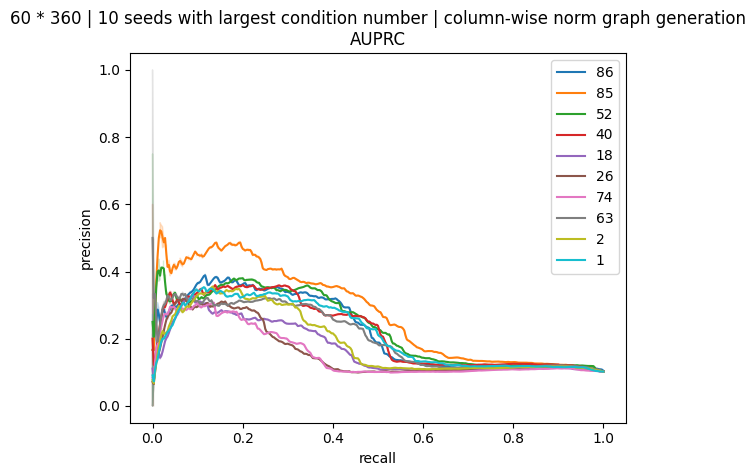

In [40]:
from sklearn.metrics import precision_recall_curve
# seed = 1
for seed in [86, 85, 52, 40, 18, 26, 74, 63, 2, 1]:
    W = load_data_39(60, 6, seed)
    W_true, B_true, X = load_true_11(60, 6, seed)
    prec, rec, threshold = precision_recall_curve(B_true.flatten(), np.abs(W).flatten())
    ax = sns.lineplot(x=rec, y=prec, alpha=1, label=seed)
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
plt.title("60 * 360 | 10 seeds with largest condition number | column-wise norm graph generation\nAUPRC")

In [42]:
from sklearn.metrics import precision_recall_curve
# seed = 1
for seed in [86, 85, 52, 40, 18, 26, 74, 63, 2, 1]:
    W = load_data_39(60, 6, seed)
    W_true, B_true, X = load_true_11(60, 6, seed)
    prec, rec, threshold = precision_recall_curve(B_true.flatten(), np.abs(W).flatten())
    ax = sns.lineplot(x=rec, y=prec, alpha=1, label=seed)
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
plt.title("60 * 360 | 10 seeds with largest condition number | column-wise norm graph generation\nAUPRC")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v39/W_60_360_86.pkl'